In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
# Load the data
df = pd.read_csv('Cancer_Data.csv')  # Assuming the data is in a CSV file
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [11]:
# Drop unnecessary columns
df.drop(['id', 'Unnamed: 32'], axis=1, inplace=True)

# Convert diagnosis to binary (M = 1, B = 0)
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

# Check for missing values (though the info shows none)
print(df.isnull().sum())

diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64


diagnosis
0    357
1    212
Name: count, dtype: int64


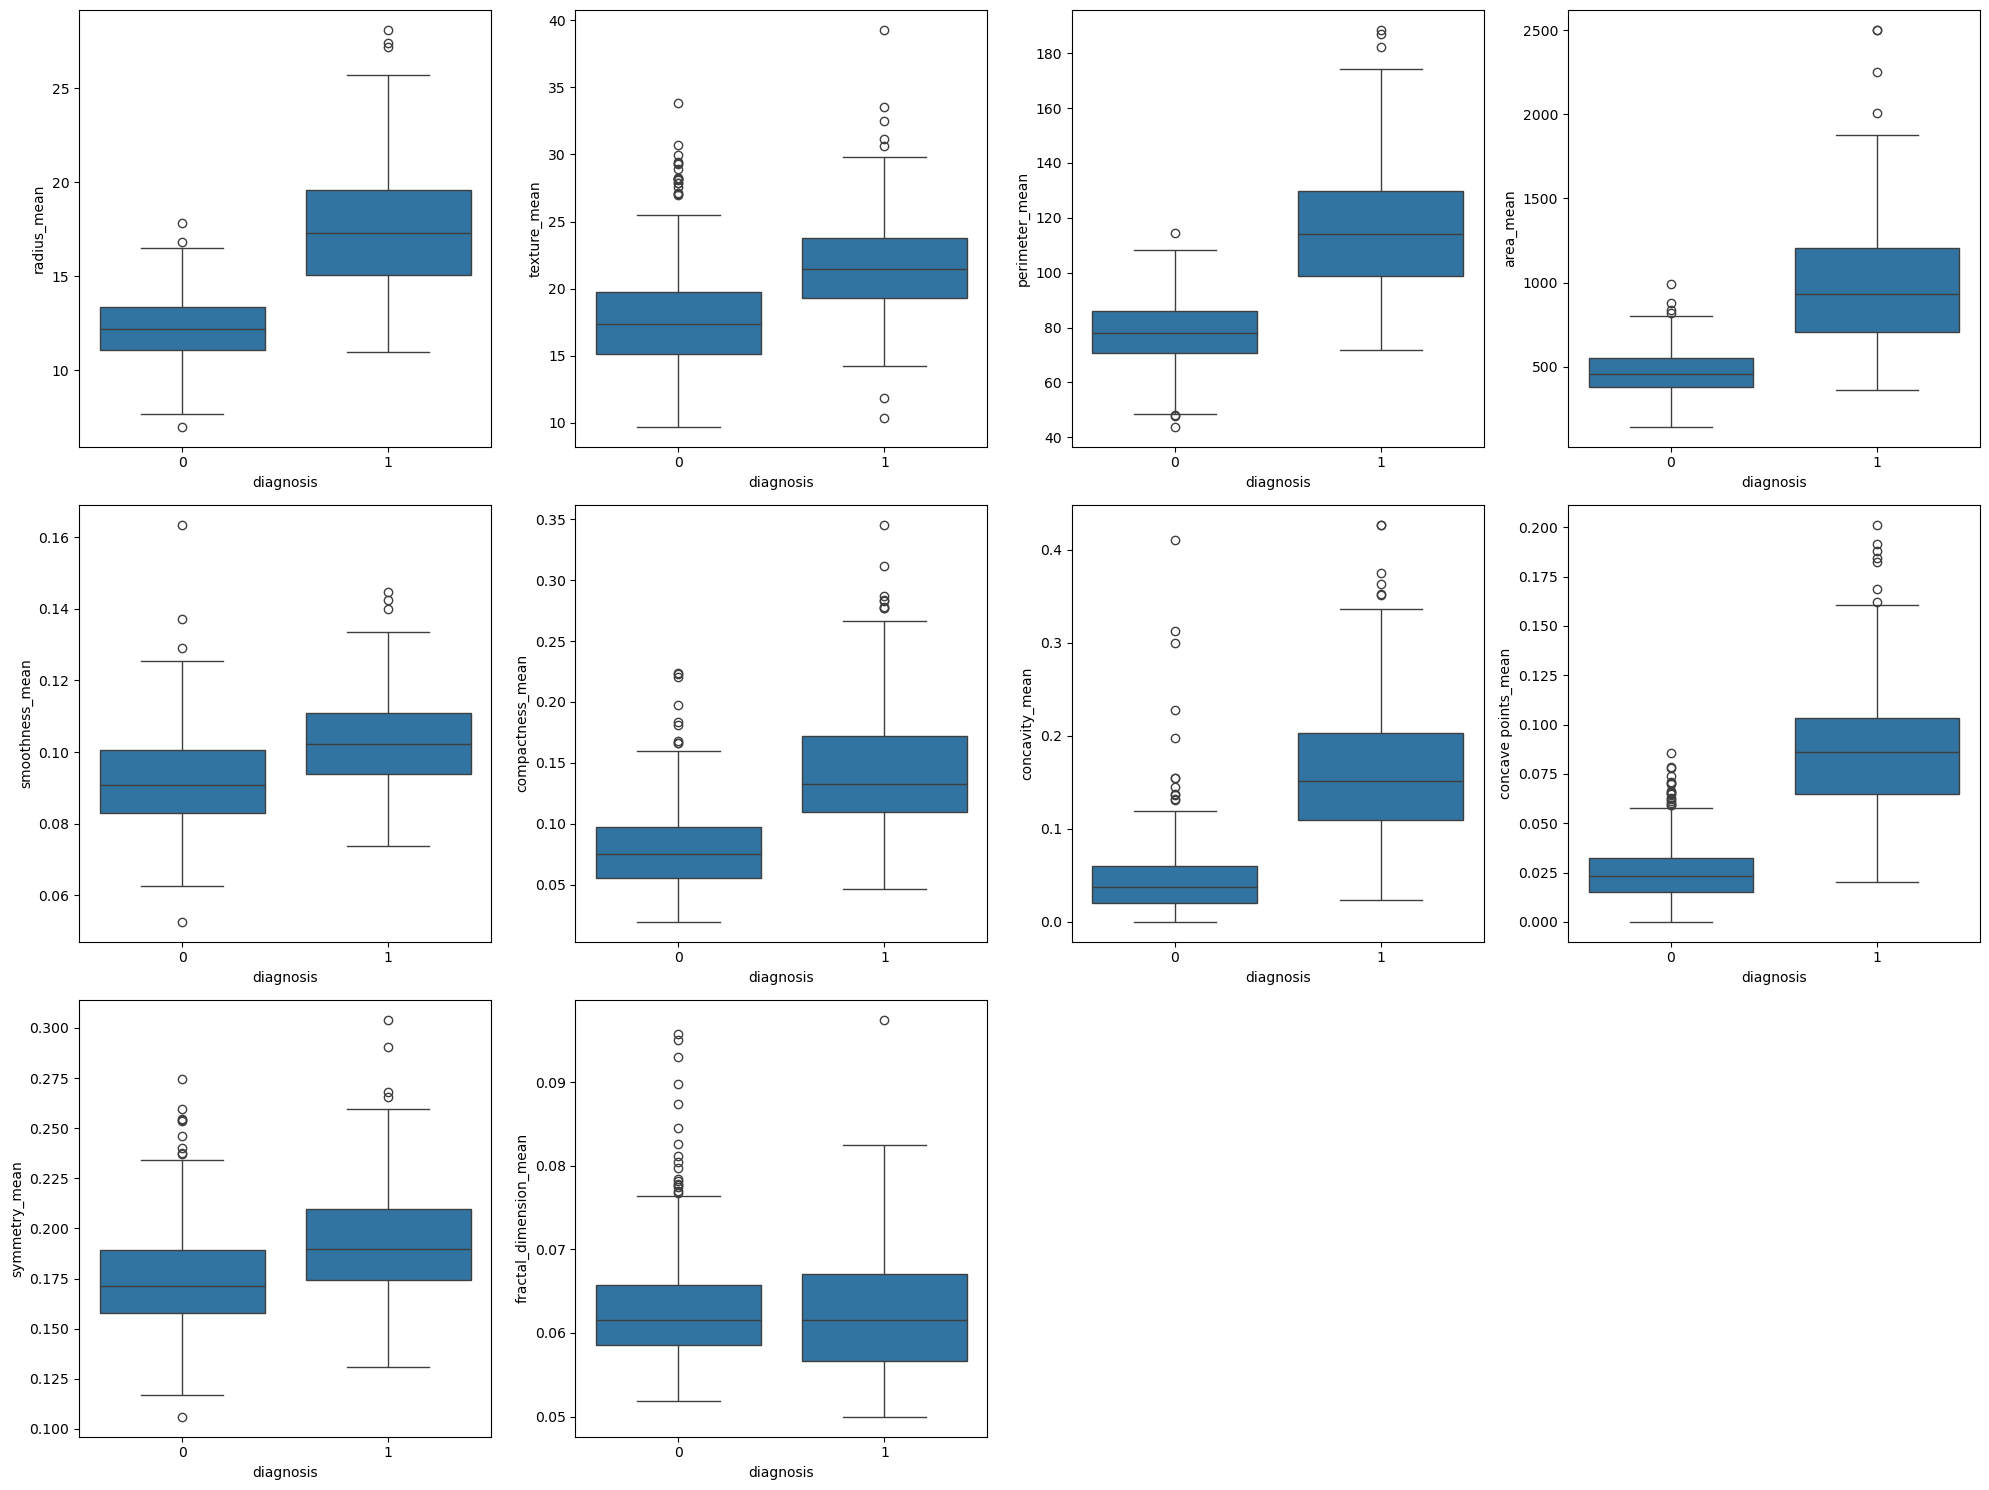

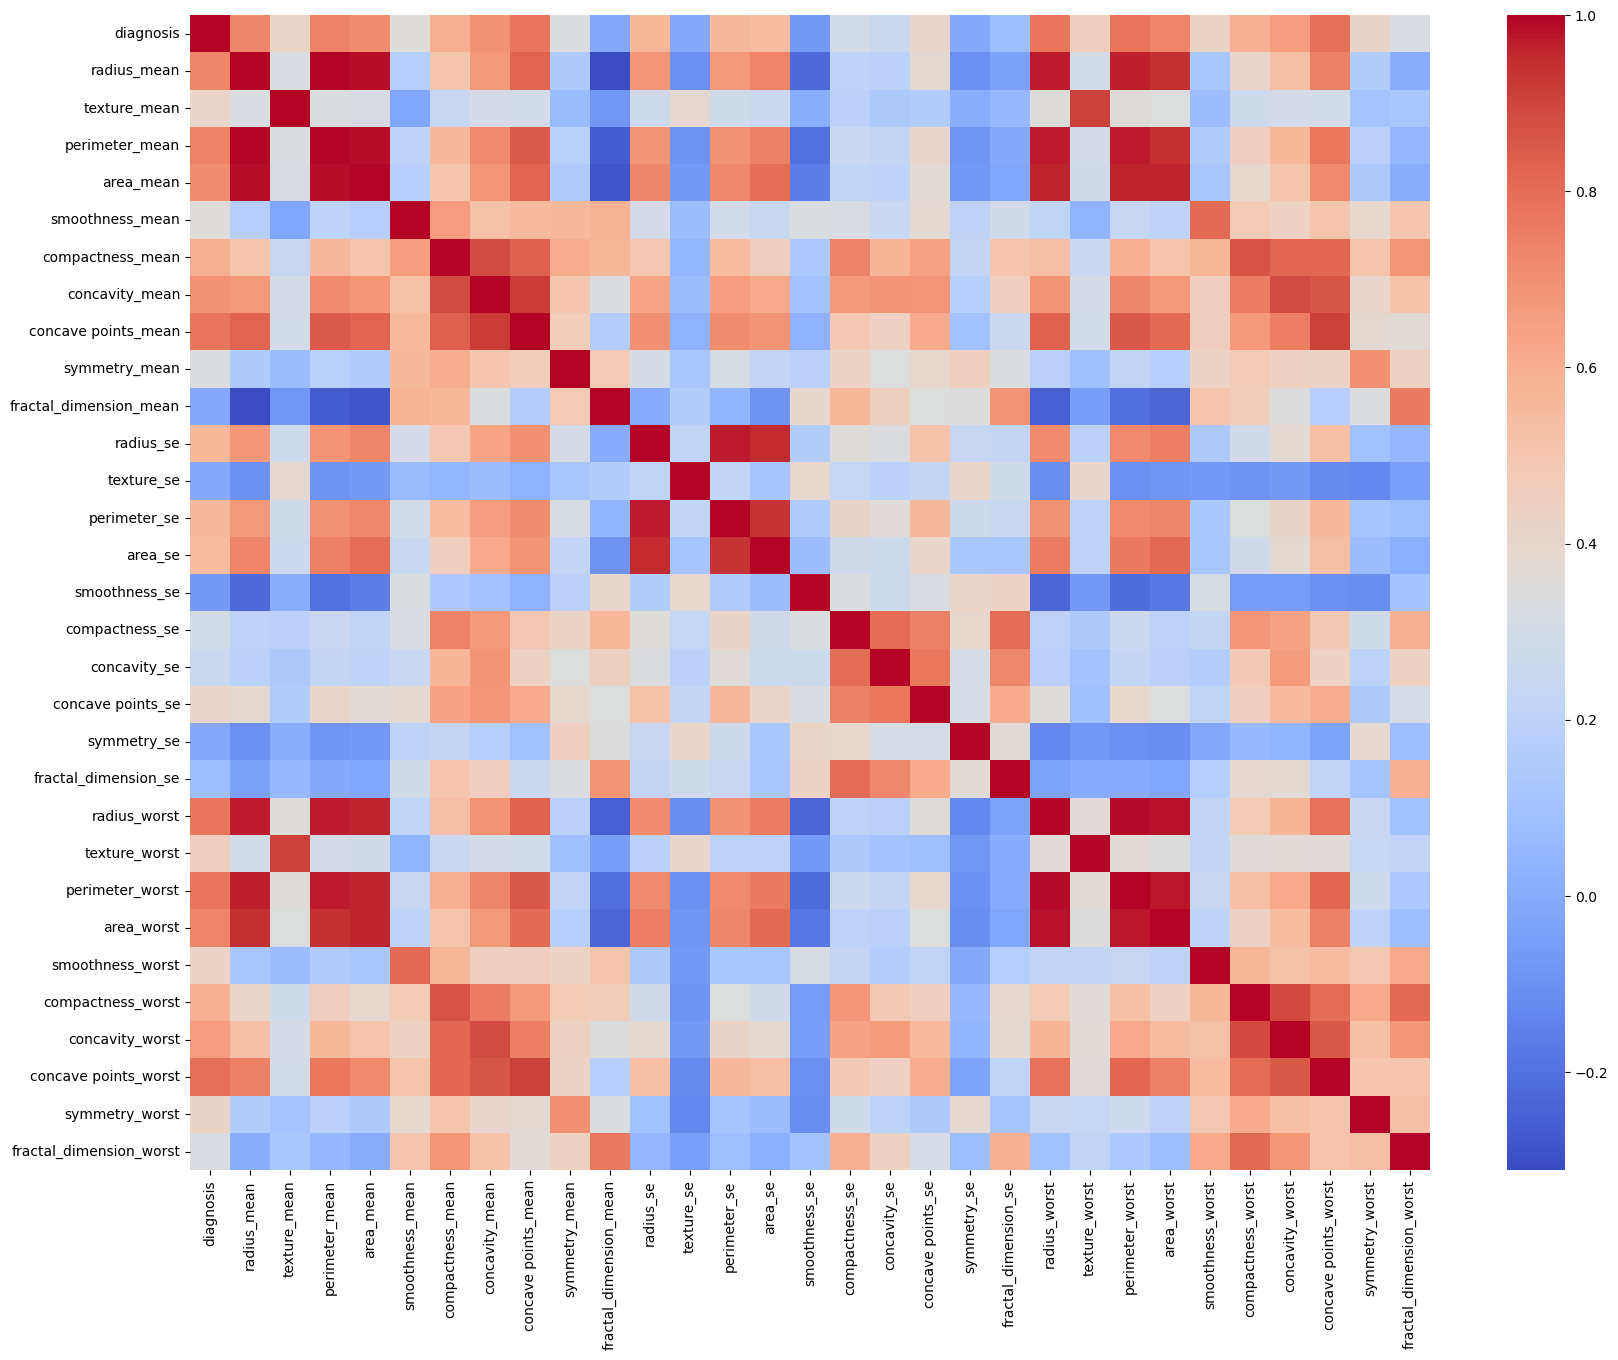

In [15]:
# Check class distribution
print(df['diagnosis'].value_counts())

# Visualize feature distributions
plt.figure(figsize=(20, 15))
for i, column in enumerate(df.columns[1:11]):  # Just first 10 features for visualization
    plt.subplot(3, 4, i+1)
    sns.boxplot(x='diagnosis', y=column, data=df)
plt.tight_layout()
plt.show()

# Check correlation matrix
plt.figure(figsize=(20, 15))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.show()

In [17]:
# Separate features and target
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

# Feature selection using ANOVA F-value
selector = SelectKBest(f_classif, k=15)  # Select top 15 features
X_selected = selector.fit_transform(X, y)

# Get selected feature names
selected_features = X.columns[selector.get_support()]
print("Selected Features:", selected_features.tolist())

# Update X with selected features
X = X[selected_features]

Selected Features: ['radius_mean', 'perimeter_mean', 'area_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'radius_se', 'perimeter_se', 'area_se', 'radius_worst', 'perimeter_worst', 'area_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst']


In [19]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [21]:
# Create and train baseline model
baseline_model = LogisticRegression(random_state=42, max_iter=1000)
baseline_model.fit(X_train_scaled, y_train)

# Evaluate
y_pred = baseline_model.predict(X_test_scaled)
print("Baseline Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Baseline Accuracy: 0.9736842105263158

Confusion Matrix:
 [[72  0]
 [ 3 39]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        72
           1       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114



In [25]:
# Define pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42, max_iter=10000))
])

# Define parameter grid with compatible solver-penalty combinations
param_grid = [
    {
        'classifier__penalty': ['l1'],
        'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'classifier__solver': ['liblinear', 'saga']
    },
    {
        'classifier__penalty': ['l2'],
        'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    },
    {
        'classifier__penalty': ['elasticnet'],
        'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'classifier__solver': ['saga'],
        'classifier__l1_ratio': [0.1, 0.5, 0.9]
    },
    {
        'classifier__penalty': [None],
        'classifier__solver': ['newton-cg', 'lbfgs', 'sag', 'saga']
    }
]

# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, error_score='raise')
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)

Best Parameters: {'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best CV Accuracy: 0.9472527472527472


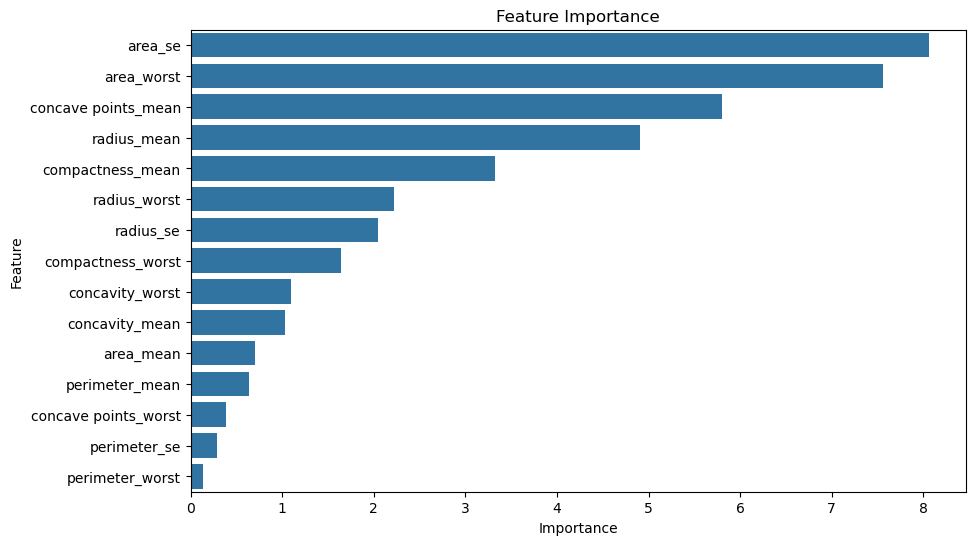

In [27]:
# Get feature importance
if hasattr(best_model.named_steps['classifier'], 'coef_'):
    coefficients = best_model.named_steps['classifier'].coef_[0]
    feature_importance = pd.DataFrame({'Feature': selected_features, 'Importance': np.abs(coefficients)})
    feature_importance = feature_importance.sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title('Feature Importance')
    plt.show()

ROC AUC Score: 0.9983465608465609


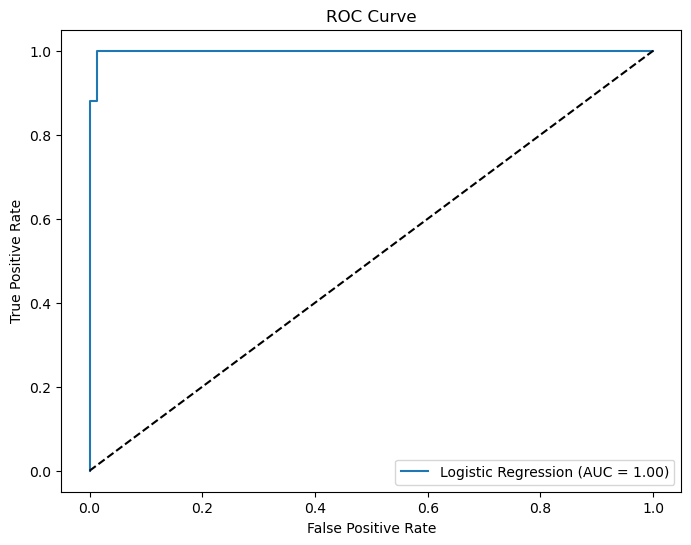

In [29]:
from sklearn.metrics import roc_auc_score, roc_curve

# Predict probabilities
y_probs = best_model.predict_proba(X_test)[:, 1]

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, y_probs)
print("ROC AUC Score:", roc_auc)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [31]:
# Step 1: Get predicted probabilities for the malignant class (1)
y_probs = best_model.predict_proba(X_test)[:, 1]

# Step 2: Find the optimal threshold to maximize recall (reduce false negatives)
from sklearn.metrics import recall_score, precision_score

thresholds = np.arange(0.1, 0.6, 0.05)  # Test thresholds from 0.1 to 0.5
best_recall = 0
best_threshold = 0.5

for threshold in thresholds:
    y_pred_adj = (y_probs >= threshold).astype(int)
    current_recall = recall_score(y_test, y_pred_adj, pos_label=1)
    if current_recall > best_recall:
        best_recall = current_recall
        best_threshold = threshold

# Step 3: Apply the best threshold
y_pred_optimized = (y_probs >= best_threshold).astype(int)

# Step 4: Evaluate the improved model
print(f"\nOptimized Threshold: {best_threshold:.2f}")
print("Optimized Confusion Matrix:\n", confusion_matrix(y_test, y_pred_optimized))
print("\nOptimized Classification Report:\n", classification_report(y_test, y_pred_optimized))
print("Optimized ROC AUC:", roc_auc_score(y_test, y_probs))


Optimized Threshold: 0.10
Optimized Confusion Matrix:
 [[66  6]
 [ 0 42]]

Optimized Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96        72
           1       0.88      1.00      0.93        42

    accuracy                           0.95       114
   macro avg       0.94      0.96      0.94       114
weighted avg       0.95      0.95      0.95       114

Optimized ROC AUC: 0.9983465608465609


In [33]:
from sklearn.metrics import f1_score

# Find threshold that maximizes F1-score (balance of precision/recall)
thresholds = np.arange(0.1, 0.5, 0.01)
best_f1 = 0
best_threshold = 0.1

for threshold in thresholds:
    y_pred_adj = (y_probs >= threshold).astype(int)
    current_f1 = f1_score(y_test, y_pred_adj, pos_label=1)
    if current_f1 > best_f1:
        best_f1 = current_f1
        best_threshold = threshold

y_pred_balanced = (y_probs >= best_threshold).astype(int)
print(f"\nBalanced Threshold: {best_threshold:.2f}")
print(confusion_matrix(y_test, y_pred_balanced))
print(classification_report(y_test, y_pred_balanced))


Balanced Threshold: 0.30
[[71  1]
 [ 0 42]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        72
           1       0.98      1.00      0.99        42

    accuracy                           0.99       114
   macro avg       0.99      0.99      0.99       114
weighted avg       0.99      0.99      0.99       114

